In [1]:
import pandas as pd
import gensim
import numpy as np
import re
#import nltk
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
import multiprocessing
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import logging  # Setting up the loggings to monitor gensim
from time import time  # To time our operations
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

C:\Users\sasaki.f\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
umlaute_dict = {
    'ä': 'ae',  # U+00E4	   \xc3\xa4
    'ö': 'oe',  # U+00F6	   \xc3\xb6
    'ü': 'ue',  # U+00FC	   \xc3\xbc
    'Ä': 'Ae',  # U+00C4	   \xc3\x84
    'Ö': 'Oe',  # U+00D6	   \xc3\x96
    'Ü': 'Ue',  # U+00DC	   \xc3\x9c
    'ß': 'ss',  # U+00DF	   \xc3\x9f
}


def replace_german_umlaute(unicode_string):

    utf8_string = unicode_string# .encode('utf-8')

    for k in umlaute_dict.keys():
        utf8_string = utf8_string.replace(k, umlaute_dict[k])

    return utf8_string#.decode()

In [3]:
input = pd.read_csv('result-with-delimiter.csv',header=0,delimiter=',', encoding='utf-8')

In [4]:
input.head()

,publication,title,keywords
0,http://linkeddata.econstor.eu/beta/resource/pu...,The desirability of workfare as a welfare orde...,welfareXXXYYYworkfareXXXYYYmisreportingXXXYYYm...
1,http://linkeddata.econstor.eu/beta/resource/pu...,"Ageing, Care Need and Long-Term Care Workforce...",DeutschlandXXXYYYPflegeberufeXXXYYYGesundheits...
2,http://linkeddata.econstor.eu/beta/resource/pu...,The experience of developing countries with ma...,Wirtschaftliche AnpassungXXXYYYEntwicklungslän...
3,http://linkeddata.econstor.eu/beta/resource/pu...,"Private information, human capital, and optima...",WeltXXXYYYfinancial marketsXXXYYYPortfolio-Man...
4,http://linkeddata.econstor.eu/beta/resource/pu...,Surveys of Informal Sector Enterprises - Some ...,informal sectorXXXYYYinformal sector enterpris...


In [5]:
for i, row in input.iterrows():
    s = str(row.iloc[2])
    replaced1 = re.sub(' ','_',s)
    replaced2= re.sub('XXXYYY', ' ', replaced1)
    replaced3= replace_german_umlaute(replaced2)
    input.set_value(i,'keywords',replaced3.lower())

C:\Users\sasaki.f\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
input.head()

,publication,title,keywords
0,http://linkeddata.econstor.eu/beta/resource/pu...,The desirability of workfare as a welfare orde...,welfare workfare misreporting means-testing ut...
1,http://linkeddata.econstor.eu/beta/resource/pu...,"Ageing, Care Need and Long-Term Care Workforce...",deutschland pflegeberufe gesundheitsberufe pfl...
2,http://linkeddata.econstor.eu/beta/resource/pu...,The experience of developing countries with ma...,wirtschaftliche_anpassung entwicklungslaender ...
3,http://linkeddata.econstor.eu/beta/resource/pu...,"Private information, human capital, and optima...",welt financial_markets portfolio-management as...
4,http://linkeddata.econstor.eu/beta/resource/pu...,Surveys of Informal Sector Enterprises - Some ...,informal_sector informal_sector_enterprises me...


In [7]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [8]:
def read_metadata_record(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

In [9]:
def training(size, sample, use_gensim_preprocessing, mincount, negative, outputname):
    documents = []
    for index, row in input.iterrows():
        if(use_gensim_preprocessing == False):
            documents.append(row['keywords'].split())
        else:
            documents.append(read_metadata_record(row,"keywords"))
    model = Word2Vec(min_count=mincount,
                     window=5,
                     size=size,
                     sample=sample,#6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=negative,#negative=20,
                     workers=cores-1)
    model.build_vocab(documents, progress_per=10000)
    model.train(sentences=documents, total_examples=len(documents), epochs=model.iter)
    model.save(outputname)
    pass

In [ ]:
use_gensim_preprocessing = False
documents = []
for index, row in input.iterrows():
    if(use_gensim_preprocessing == False):
        documents.append(row['keywords'].split())
    else:
        documents.append(read_metadata_record(row,"keywords"))
model = Word2Vec(workers=cores-1)
model.build_vocab(documents, progress_per=10000)
model.train(sentences=documents, total_examples=len(documents), epochs=model.iter)
model.save("defaults-without-gensim-preprocessing.model")

C:\Users\sasaki.f\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
INFO - 16:55:54: collecting all words and their counts
INFO - 16:55:54: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:55:54: PROGRESS: at sentence #10000, processed 66973 words, keeping 22202 word types
INFO - 16:55:55: PROGRESS: at sentence #20000, processed 134000 words, keeping 35698 word types
INFO - 16:55:55: PROGRESS: at sentence #30000, processed 201264 words, keeping 47317 word types
INFO - 16:55:55: PROGRESS: at sentence #40000, processed 268607 words, keeping 57151 word types
INFO - 16:55:55: PROGRESS: at sentence #50000, processed 336504 words, keeping 66029 word types
INFO - 16:55:55: PROGRESS: at sentence #60000, processed 403739 words, keeping 74347 word types
INFO - 16

In [ ]:
model = Word2Vec.load("defaults.model")

In [ ]:
def analyseModel(model):
    word_vectors = model.wv
    number_of_samples = len(word_vectors.vocab) // 10
    length = str(len(word_vectors.vocab))
    randomNumbers = np.random.randint(low=1, high=length, size=number_of_samples) 
    totalSum = 0
    for n in randomNumbers:
        word = word_vectors.index2word[int(n)]
        values = [value[1] for value in word_vectors.most_similar(word)]
        totalSum += sum(values) / len(values)
    return(totalSum / number_of_samples)

In [ ]:
def print_model_parameters(model):
    parameters = ""
    parameters += "\t" + str(model.corpus_total_words)
    parameters += "\t" + str(model.epochs)
    parameters += "\t" + str(model.layer1_size)
    parameters += "\t" + str(model.min_alpha)
    parameters += "\t" + str(model.min_count)
    parameters += "\t" + str(model.sample)
    parameters += "\t" + str(model.negative)
    parameters += "\t" + str(analyseModel(model))
    return parameters

In [ ]:
import os
model_analysis = "filename" + "\t" + "vocabulary size" + "\t" + "epochs" + "\t" + "hidden layer size" + "\t" + "learning rate" + "\t" + "min count" + "\t" + "downsampling" + "\t" + "negative sampling" + "\t" + "model quality"  
rootdir = '.'
extensions = ('.model')
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            model_analysis += "\n" + str(file) 
            model = Word2Vec.load(str(file))
            model_analysis += print_model_parameters(model)
f= open("model-analysis.csv","w", encoding="utf-8")
f.write(model_analysis)
f.close()

In [ ]:
analysis = pd.read_csv('model-analysis.csv',sep='\t', encoding='utf-8')

In [ ]:
analysis.sort_values(by=['model quality'],ascending=False)

In [ ]:
model = Word2Vec.load('training18.model')

In [ ]:
model.wv.most_similar('deutschland')

In [68]:
vocabulary = model.wv.vocab.keys()
output = ""
type(vocabulary)
f= open("vocabulary-defaults.txt","w", encoding="utf-8")
for x in vocabulary:
    output += str (x) + "\n"
f.write(output)
f.close()

In [85]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         title = df["words"][line].title()
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + re.sub('_',' ',title),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

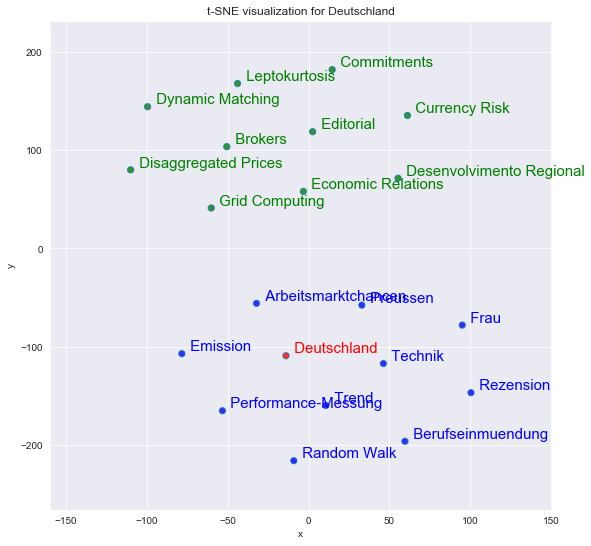

In [86]:
tsnescatterplot(model, 'deutschland', [i[0] for i in model.wv.most_similar(negative=['deutschland'])])